<font size="7"><b>Grid Search Hyperparameter Optimization</b></font>

This case study is all about using Grid Searches to identify the optimal parameters for a machine learning algorithm. To complete this case study, you'll use the <a href="https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database"><b>Pima Indian diabetes dataset</b> from Kaggle</a> and the KNN algorithm. Follow along with the preprocessing steps of this case study.

## 1.1. Dependencies

In [182]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
sns.set()

In [183]:
# set random seed to try make this exercise and solutions reproducible (NB: this is just for teaching purpose and not something you would do in real life)
random_seed_number = 42
np.random.seed(random_seed_number)

In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2. Functions

### <b><code>plot_histograms_of_each_column()</code></b>

In [185]:
def plot_histograms_of_each_column(
    df
):

    """
    Plot histograms for each column in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data for which histograms are to be plotted.

    Returns:
    None
    """

    # Set the background color to white
    plt.rcParams['axes.facecolor'] = 'white'

    # Adjust the overall figure size
    fig, axes = plt.subplots(
          nrows=3
        , ncols=3
        , figsize=(7, 7)
    )

    # Create histograms with solid black lines for axes
    for i, column in enumerate(df.columns):
        ax = axes[i // 3, i % 3]
        df[column].plot(
              kind      = 'hist'
            , ax        = ax
            , color     = 'darkgrey'
            , edgecolor = 'black'
        )

        # Set the borders (top, bottom, left, right) to black solid lines
        for spine in ax.spines.values():
            spine.set_color('black')

        # Turn off gridlines
        ax.grid(False)

        # Add solid black lines for the axes
        borders = ['top', 'left', 'bottom', 'right']
        for border in borders:
          ax.spines[border].set_color('black')

        ax.set_title(column)

    # Adjust the size of each individual subplot
    plt.tight_layout()

    # Show the plot
    plt.show()


### <b><code>plot_correlation_heatmap()</code></b>

In [186]:
def plot_correlation_heatmap(
    df
):

    """
    Plot a heatmap to visualize the correlation matrix of a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing numeric columns.

    Returns:
    None (Displays the heatmap plot).
    """

    plt.figure(figsize=(7, 5))
    print('Correlation between various features')

    # Set the font size for axis ticks and annotations
    annot_font_size      = 8
    axis_ticks_font_size = 10

    # Create a mask to hide the upper triangular portion
    mask = np\
          .tri(df.corr().shape[0], k=-1)\
          .T

    p = sns.heatmap(
          df.corr()
        , annot       = True
        , cmap        = 'coolwarm'
        , annot_kws   = {'fontsize': annot_font_size}
        , xticklabels = True
        , yticklabels = True
        , mask        = mask
        , cbar        = True
        , vmin        = -1
        , vmax        =  1
    )

    # Set the font size for x and y axis ticks
    p.set_xticklabels(p.get_xticklabels(), fontsize=axis_ticks_font_size)
    p.set_yticklabels(p.get_yticklabels(), fontsize=axis_ticks_font_size)

    plt.title(
          'Correlation Matrix'
        , fontsize = 16
    )

    plt.show()

### <b><code>plot_confusion_matrix()</code></b>

In [253]:
def plot_confusion_matrix(
      y_test
    , y_pred
    , classes
    , normalize     = False
    , show_colorbar = False
    , cmap          = plt.cm.Blues
    , figsize       = (4, 4)
):

    """
    Plot the confusion matrix to visualize model performance.

    Parameters:
        - y_test: True labels from the test dataset.
        - y_pred: Predicted labels from the model.
        - classes: List of class (label, category) names.
        - normalize: Whether to normalize the confusion matrix. Default is False.
        - show_colorbar: Whether to show the color bar. Default is False.
        - cmap: Colormap for the visualization. Default is plt.cm.Blues.
        - figsize: Size of the figure (width, height). Default is (4, 4).

    Returns:
        - None

    This function generates a confusion matrix plot to help assess the performance
    of a classification model. It can display both the raw counts and normalized values
    (if 'normalize' is True) horizontally when the 'normalize' parameter is set to True.

    Example usage:
    plot_confusion_matrix(y_test, y_pred, classes=['Class 0', 'Class 1'], normalize=True, figsize=(6, 6))
    """

    # Set figure size
    fig, axes = plt.subplots(
          1
        , 2 if normalize else 1
        , figsize = (2 * figsize[0] + 2, figsize[1])
        , squeeze = False
    )
    # ----------------------------------------
    #            Confusion Matrix
    # ----------------------------------------
    ax1 = axes.flat[0]

    cm = confusion_matrix(
          y_test
        , y_pred
    )

    im1 = ax1.imshow(
          cm
        , interpolation = 'nearest'
        , cmap          = cmap
    )

    ax1.set_title('Confusion Matrix'+'\n'+'')
    ax1.set_xticks(np.arange(len(classes)))
    ax1.set_yticks(np.arange(len(classes)))
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes)
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    ax1.grid(False)

    # Calculate the midpoint of the colormap to determine the "darkness" threshold
    midpoint = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        cell_bg = cm[i, j]
        text_color = "white" if cell_bg > midpoint else "black"
        ax1.text(
              j
            , i
            , format(cm[i, j], 'd')
            , horizontalalignment = "center"
            , color               = text_color
        )

    # Add the color bar if show_colorbar is True
    if show_colorbar:
        divider1 = make_axes_locatable(
            ax1
        )

        cax1 = divider1.append_axes(
              "right"
            , size = "5%"
            , pad  = 0.15
        )

        # fig.colorbar(
        #       im1
        #     , ax          = axes.ravel().tolist()
        #     , orientation = 'vertical'
        # )

        plt.colorbar(
              im1
            , cax = cax1
        )
    # ----------------------------------------
    #            Confusion Matrix
    #              (Normalized)
    # ----------------------------------------
    if normalize:
        ax2 = axes.flat[1]

        cm_normalized = confusion_matrix(
              y_test
            , y_pred
            , normalize = 'true'
        )

        im2 = ax2.imshow(
              cm_normalized
            , interpolation = 'nearest'
            , cmap          = cmap
        )

        ax2.set_title('Confusion Matrix\n(Normalized)')
        ax2.set_xticks(np.arange(len(classes)))
        ax2.set_yticks(np.arange(len(classes)))
        ax2.set_xticklabels(classes, rotation=45)
        ax2.set_yticklabels(classes)
        ax2.set_ylabel('True label')
        ax2.set_xlabel('Predicted label')
        ax2.grid(False)

        # Display the numbers using float format
        for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
            cell_bg = cm_normalized[i, j]
            text_color = "white" if cell_bg > 0.5 else "black"
            ax2.text(
                  j
                , i
                , format(cm_normalized[i, j], '.2f')
                , horizontalalignment = "center"
                , color               = text_color
            )

        # Add the color bar for normalized confusion matrix if show_colorbar is True
        if show_colorbar:
            divider2 = make_axes_locatable(
                ax2
            )

            cax2 = divider2.append_axes(
                  "right"
                , size = "5%"
                , pad  = 0.15
            )

            fig.colorbar(
                  im2
                , cax  = cax2
                , norm = plt.Normalize(vmin=0, vmax=1)
            )
    # ----------------------------------------
    # Adjust layout to prevent color bar overlap
    plt.tight_layout()

    fig.subplots_adjust(
        wspace=0.4
    )

    plt.show()

### <b><code>print_model_performance()</code></b>

In [188]:
def print_model_performance(
      k_values
    , train_scores
    , test_scores
):

    """
    Display the performance of a machine learning model for different numbers of neighbors (K).

    Parameters:
    - k_values (list or array-like): List of K values (model's complexity) used for model evaluation.
    - train_scores (list or array-like): List of train scores for each corresponding K value.
    - test_scores (list or array-like): List of test scores for each corresponding K value.

    This function creates a DataFrame to organize and display the model's performance metrics
    for various values of K, including both training and testing scores. The DataFrame is
    printed without truncation and without including the index column, ensuring that all
    data is shown clearly.

    Usage:
    Provide lists or arrays of K values, train scores, and test scores to this function to
    visualize and compare the performance of a machine learning model at different levels
    of complexity (K values).

    Example:
    k_values = [1, 3, 5, 7, 9]
    train_scores = [0.85, 0.88, 0.90, 0.92, 0.94]
    test_scores = [0.75, 0.78, 0.82, 0.80, 0.76]
    print_model_performance(k_values, train_scores, test_scores)
    """

    data = {
        'K'           : k_values
      , 'Train Score' : train_scores
      , 'Test Score'  : test_scores
    }

    df = pd.DataFrame(
        data
    )

    with pd.option_context(
          'display.max_rows'
        , None
        , 'display.max_columns'
        , None
    ):
        print(df.to_string(index=False))

### <b><code>plot_model_performance()</code></b>

In [189]:
def plot_model_performance(
      train_scores
    , test_scores
):

    """
    Plot the model performance based on train and test scores.

    Parameters:
    - train_scores (list or array-like): Training scores for different hyperparameters.
    - test_scores (list or array-like): Test scores for different hyperparameters.

    Returns:
    None
    """

    # Set the background color to white
    plt.figure(figsize=(7, 5))
    plt.rcParams['axes.facecolor'] = 'white'

    x_values = np.arange(1, len(train_scores) + 1)

    # Create line plots with dashed lines
    p1 = sns.lineplot(
          x         = x_values
        , y         = train_scores
        , marker    = 'D'
        , label     = 'Train'
        , linestyle = 'dashed'
        , color     = 'darkgrey'
    )

    p2 = sns.lineplot(
          x         = x_values
        , y         = test_scores
        , marker    = 'o'
        , label     = 'Test'
        , linestyle = 'dashed'
        , color     = 'black'
    )

    # Set the borders (top, bottom, left, right) to black solid lines
    for spine in plt.gca().spines.values():
        spine.set_color('black')

    # Label axes
    plt.xlabel('Number of Neighbors ($k$)')
    plt.ylabel('Score')

    # Add title
    plt.title(
          "Model Performance"
        , fontsize=16
    )

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

### <b><code>ytest_vs_pred()</code></b>

In [190]:
def ytest_vs_ypred(
      ytest
    , ypred
    , classes                    = []
    , reset_index_col_name_to    = ''
    , num_rows_to_show_in_output = 20
):

    """
    Display the comparison between actual labels and predicted labels, optionally mapping numeric labels to class names.

    Parameters:
    - ytest (list or array-like): List of actual labels.
    - ypred (list or array-like): List of predicted labels.
    - classes (list, optional): List of class names to map numeric labels to. Default is an empty list ([]).
    - reset_index_col_name_to (str, optional): Name to reset the index column to. Default is an empty string ('').
    - num_rows_to_show_in_output (int, optional): Number ofrows to show in the output. Default is 20.

    This function creates a DataFrame to visualize and compare the actual labels ('ytest') and predicted labels ('ypred').
    It can also map numeric labels to class names when the 'classes' argument is provided, making it easier to interpret
    the results.

    Usage:
    Provide actual labels ('ytest') and predicted labels ('ypred') as lists or arrays. Optionally, provide a list of class
    names ('classes') to map numeric labels to class names. You can also specify a name to reset the index column to using
    the 'reset_index_col_name_to' argument. It only shows the first 'num_rows_to_show_in_output' rows (i.e., observations)
    in the output for comparison between actual and predicted values.

    Example:
    y_test = [0, 1, 2]
    y_pred = [1, 2, 0]
    classes = ['Class A', 'Class B', 'Class C']
    reset_index_col_name = 'Patient ID'
    num_rows_to_show_in_output = 50
    ytest_vs_ypred(y_test, y_pred, classes, reset_index_col_name, num_rows_to_show_in_output)
    """

    data = {
          'Actual label'    : ytest
        , 'Predicted label' : ypred
    }

    df = pd.DataFrame(data)
    df = df.rename_axis(reset_index_col_name_to)

    # Define the mapping dictionary for replacement
    mapping_dict = {i: cls for i, cls in enumerate(classes)}

    # List of columns to replace values in
    columns_to_replace = df.columns

    # Replace values in the specified columns
    df[columns_to_replace] = df[columns_to_replace].replace(mapping_dict)

    return df.head(num_rows_to_show_in_output)

---

# 2. Load

In [191]:
file_path = "/content/drive/MyDrive/Colab Notebooks/data/18.2.4.diabetes.csv"
diabetes_data = pd.read_csv(file_path)

In [192]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


---

# 3. EDA

## 3.1. Overview

In [193]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* The dataset contains a total of <b><code>768 rows</code></b> (<i>AKA</i>  observations or entries). All columns have <b><code>768 non-null</code></b> (non-missing) values, indicating that there are no missing values in any of the columns. This suggests that the dataset is complete in terms of data availability for all variables.

* The columns in our dataset are either using <b><code>int64</code></b> or <b><code>float64</code></b> data types, which are the right choices for the kinds of data we have. There are no categorical variables in the dataset.

## 3.2. Missing Values ?

<b>However, the first statement above is incorrect! A closer look reveals that even though the dataset doesn't have any missing values, it has replaced them with zeros, which is why they weren't immediately noticeable!</b>

### Detection

Let's make a boolean mask to count how many rows in the dataset have at least one zero value in any of predictors (except for <b><code>'Pregnancies'</code></b>):

<b><code>['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']</code></b>

> <b>NOTE:</b> The presence of zero values in the <b><code>'Pregnancies'</code></b> column may be interpreted as either:
  * "zero pregnancies" ; or
  * A potential indication of missing data
>  
> To deal with this uncertainty when imputing missing data for predictors, we exclude this predictor from the rest.

<font size="4">$\large\textbf{I.}$ Create a list of predictors with potential missing values</font>

In [194]:
columns_to_check = [
      'Glucose'
    , 'BloodPressure'
    , 'SkinThickness'
    , 'Insulin'
    , 'BMI'
]

<font size="4">$\large\textbf{II.}$ Create a boolean mask for rows with at least one zero in the specified columns</font>

In [195]:
mask = (diabetes_data[columns_to_check])\
        .eq(0)\
        .any(axis=1)

<font size="4">$\large\textbf{III.}$ Filter the DataFrame to include only rows with at least one missing value</font>

In [196]:
filtered_data = diabetes_data[mask]

filtered_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0


><font size="3" color="black"><b>NOTE:</b></font> <font size="4" color="darkred"> As shown above, there are <b><code>376 rows</code></b> in total having at least a missing value (i.e., meaningless zero) in of the those columns we checked. Shortly, we will see how to impute these MISLEADING zeroes with:
> <font size="3" color="darkred">
> * <font size="3" color="darkred"> First, <b><code>NaN</code></b> values (Section 4.1. Missing Data Imputation (A) ).</font>
> * <font size="3" color="darkred"> Then, column <b><code>.mean()</code></b> or <b><code>.median()</code></b> , based on the distribution and skewness of each column specified in the list above (Section 4.1. Missing Data Imputation (B) ).</font>
><br>
> <font size="3" color="black"><b>REMEMBER</b></font>, it is always important to unite with your data and inspect the dataset in all means.
</font>

### Why not replacing missing values with zeroes ?

Using zeroes to replace missing values (NaNs) in a dataset can have several disadvantages, especially when compared to imputing missing values with column means or medians:

<b>1. Bias in Data</b>

  Imputing missing values with zeroes can introduce a significant bias into the dataset, especially when the zero values do not accurately represent the actual values that should be there. This can distort the statistical properties of the data, including the mean, median, and variance, leading to inaccurate analysis and modeling.

<b>2. Loss of Information</b>

  Replacing missing values with zeroes essentially removes the information that was missing in the first place. This loss of information can impact the quality of subsequent analysis and modeling, as valuable data may be discarded.

<b>3. Misleading Results</b>

  Using zeroes as imputations can lead to misleading results in statistical analyses. It can affect correlations, distributions, and relationships between variables, making it challenging to draw valid conclusions from the data.

<b>4. Impact on Machine Learning Models</b>

  Machine learning models may perform poorly when trained on data with missing values replaced by zeroes. The models can learn to treat these zeros as meaningful values, leading to incorrect predictions and reduced model accuracy.

<b>5. Skewed Distributions</b>

  Replacing missing values with zeroes can skew the distribution of the affected columns, making them appear more concentrated around zero than they actually are. This can affect the normality assumptions of statistical tests and machine learning algorithms.

<b>6. Invalid Inferences</b>

  Using zeroes as imputations can result in invalid inferences about the data. For example, if you are studying the relationship between variables, the presence of artificially added zeroes can lead to incorrect conclusions about the associations between variables.

<b>7. Loss of Context</b>

  In some cases, the reason for missing values may carry important context or meaning. Replacing them with zeroes can mask the underlying reasons for the missing data, making it difficult to understand the true nature of the data and its potential implications.

## 3.2. Summary Statistics

In [197]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


><b>NOTE:</b> <font size="3" color="darkred"> As mentioned above, later on in the notebook, we will see how descriptive statistics (e.g., mean, median) of each column will change when we impute the missing data (NaN values) with other meaningful tools rather than zeroes!</font>

## 3.3. Visualize (1/3)

For now, let's visualize the distribution oif each column with taking this into consideration that missing values have been replaced by zeroes across all columns in the dataset. You can compare the <b>Visualize (1/3)</b> plots here with those in <b>Visualize (2/3)</b> and <b>Visualize (3/3)</b> subunits, in section <b><code>4.1.</code></b> , to see how using other meaningful statistics such as mean and median can affect data distribution each column.

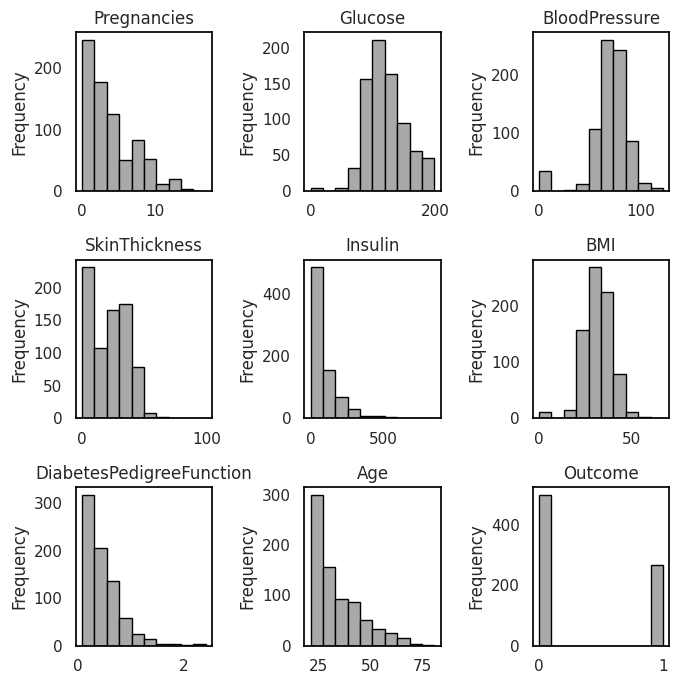

In [198]:
plot_histograms_of_each_column(
    diabetes_data
)

---

# 4. Data Preprocessing

## 4.1. Data Imputation

### Missing Data Imputation (A)

As discussed in subunit <b><code>3.2.</b></code> , the missing values in the dataset are represented as zeroes. Let's replace the <b><code>0</code></b> values </code></b> with <b><code>NaN</code></b> , in all predictors, except for <b><code>Pregnancies</code></b> which makes sense to have zero values :

<b><code>columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']</code></b>

In [199]:
# List of columns to replace zeros with NaN
columns_to_replace = columns_to_check

In [200]:
# Replace zeros with NaN in the specified columns
diabetes_data[columns_to_replace] = diabetes_data[columns_to_replace]\
                                    .replace(0, np.nan)

In [201]:
diabetes_data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


### Overview

In [202]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


These results perfectly align with what we say earlier in subsection <b><code>3.2.</b></code> While the total number of missing values in the entire dataset may be higher when considering missing values in multiple columns, the dataset contains at least <b><code>768 - 394 = 374 null</code></b> (i.e., missing or <b><code>NaN</code></b>) values in the <b><code>'Insulin'</code></b> column .

### Summary Statistics

In [203]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


As an additional validation, it is noteworthy that how the (arithmic) mean of , for example, column <b><code>'BloodPressure'</code></b> increased (from <b><code>69.105469</code></b> to <b><code>72.405184</code></b>) , when <b><code>0</b></code>'s were replaced with <b><code>NaN</code></b> (Not-a-Number) values in that column.

### Visualize (2/3)

Now, let us examine how the replacement of <b><code>0</b></code> values with <b><code>NaN</b></code> (Not-a-Number) values affects the distribution of each column. Feel free to compare the figures presented below with those depicted in subsection <b><code>3.3.</b></code> for a visual representation of the changes.

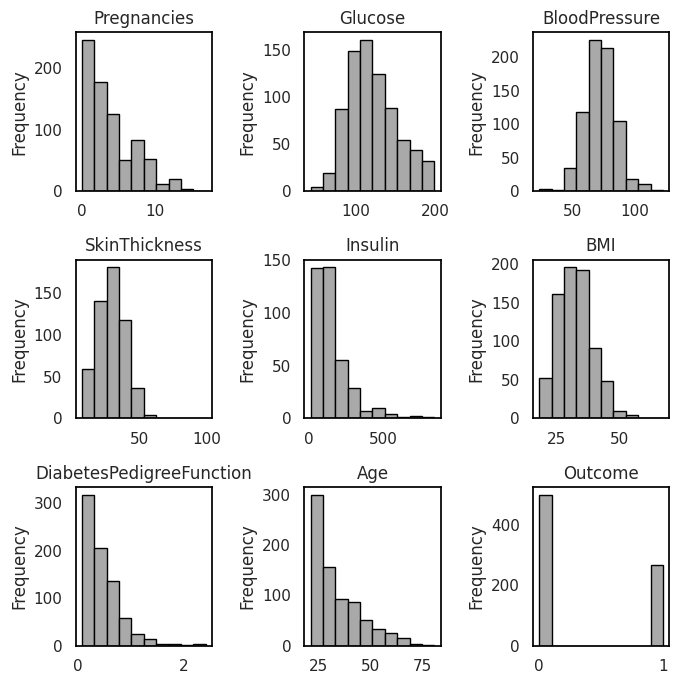

In [204]:
plot_histograms_of_each_column(
    diabetes_data
)

### Missing Data Imputation (B)

The choice between using the mean and median for imputing missing values depends on the distribution and characteristics of the data in each specific column. Here, for the columns:

1. <b><code>'Glucose'</code></b> and <b><code>'BloodPressure'</code></b> , the <b>mean</b> was used for imputation.
  * These columns typically follow a <b>relatively symmetric and nearly normal distribution</b>, where the mean is a good representation of the central tendency of the data.
  * Imputing with the mean helps maintain the overall shape and center of the distribution.

2. <b><code>'SkinThickness'</code></b> , <b><code>'Insulin'</code></b> , and <b><code>'BMI'</code></b>, the <b>median</b> was implemented for imputation.
  * These columns can have <b>skewed or non-normally distributed data with potential outliers</b> , therefore, the median is a more robust measure of central tendency because it is less affected by extreme values or outliers.
  * Imputing with the median helps prevent the imputed values from being heavily influenced by these outliers.

In [205]:
# Replace the zeros with mean and median values.
imputation_values = {
      'Glucose'       : diabetes_data['Glucose'].mean()
    , 'BloodPressure' : diabetes_data['BloodPressure'].mean()
    , 'SkinThickness' : diabetes_data['SkinThickness'].median()
    , 'Insulin'       : diabetes_data['Insulin'].median()
    , 'BMI'           : diabetes_data['BMI'].median()
}

diabetes_data.fillna(
      imputation_values
    , inplace = True
)

### Overview

In [206]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


### Summary Statistics

In [207]:
diabetes_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,125.0,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,29.0,125.0,30.1,0.349,47,1


### Visualize (3/3)

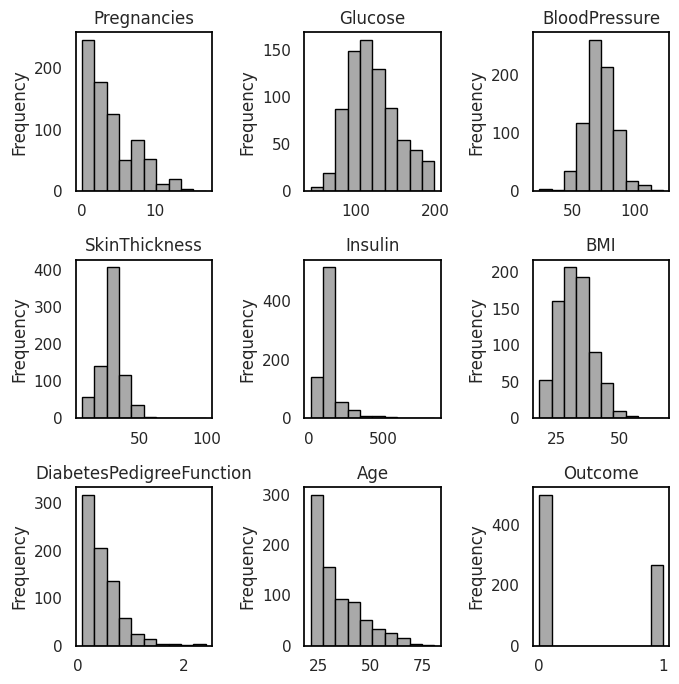

In [208]:
plot_histograms_of_each_column(
    diabetes_data
)

## 4.2. Variable Correlations

Correlation between various features


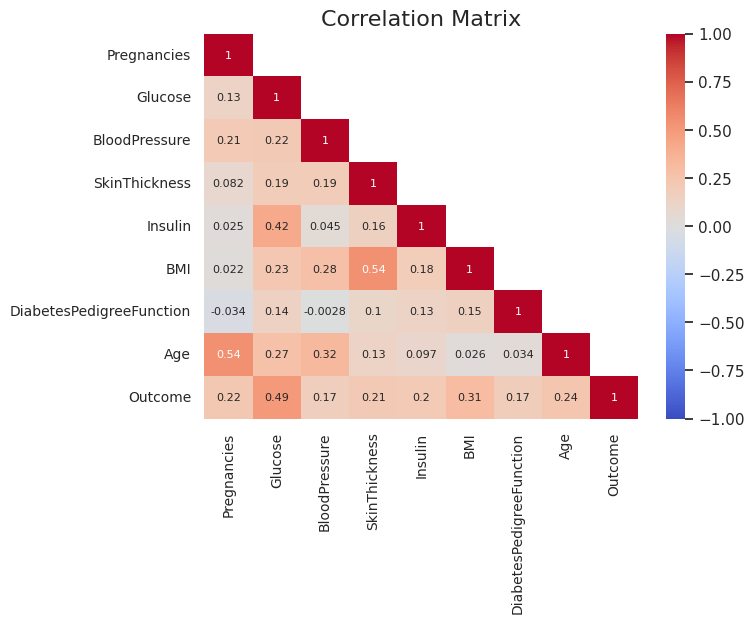

In [209]:
plot_correlation_heatmap(
    diabetes_data
)

Here are some inferences based on the heatmap:

1. <b>Insulin and Glucose</b>

  There is a moderate positive correlation of 0.42 between Insulin and Glucose, which is expected as insulin levels typically increase in response to increased glucose levels.

2. <b>Outcome Correlations</b>

  Other than glucose, the Outcome variable has relatively low to moderate correlations with other factors. This suggests that while glucose is a strong indicator, other factors also contribute to the Outcome variable but to a lesser extent.

3. <b>Low Correlation between Predictors</b>

  Most variables have low to moderate correlations with each other. This is good for building predictive models because it suggests that the variables carry unique information.

4. <b>No Strong Negative Correlations</b>

  There are no strong negative correlations present in the matrix, which means there are no pairs of variables that have a strong inverse relationship.

## 4.3. <b><code>y</code></b> and <b><code>X</code></b>

### Target

In [210]:
# Target vector (variable)
target = 'Outcome'
y = diabetes_data[target]

### Features

In [211]:
# Features matrix

features = []

for column in diabetes_data.columns:
    if column != target:
        features.append(column)

X = diabetes_data[features]

## 4.4. Train/Test Split

In [212]:
# Split X and y into Train and Test splits with size 70%/30%
X_train, X_test, y_train, y_test = train_test_split(
      X
    , y
    , test_size    = 0.3
    , random_state = 42
)

## 4.5. Feature Scaling

Using <b><code>sklearn</code></b> , standarize the magnitude of the Features <b><code>X</code></b> by scaling the values.

><font color="darkred"><b>NOTE:</b> It's important to keep a critical point in mind to prevent a particular issue known as "data leakage" when working with feature standardization (also known as normalization or scaling). The key principle is to maintain a strict separation between your training data (<b><code>X_train</code></b>) and your testing data (<b><code>X_test</code></b>).</font>
>
><font color="darkred">Here's how you should proceed:</font>
>
>1. <b><code>fit()</code></b> the scaler:
>
>   When you're ready to standardize your features, begin by using the <b><code>fit()</code></b> method exclusively on your training data (<b><code>X_train</code></b>). This step essentially calibrates the scaler to understand the statistical properties of your training data.
>
>2. <b><code>transform()</code></b> with caution:
>
>   After the scaler has been adequately trained on <b><code>X_train</code></b>, you can then confidently use it to <b><code>transform()</code></b> both your training and testing data (<b><code>X_test</code></b>). However, it's crucial to avoid any <b><code>fit()</code></b> operations on the testing data.
>
><font color="darkred">By strictly adhering to this procedure, you ensure that your scaling process is based solely on the training data's characteristics, preventing any unintentional "leakage" of information from your testing data. This rigorous separation is fundamental for unbiased model evaluation.</font>

In [213]:
# Create a MinMaxScaler instance
mm_scaler = MinMaxScaler()

# Fit on X_train
X_train_minmax = mm_scaler.fit(
    X_train
)

# Transform to X_test
X_train_minmax.transform(
    X_test
)

array([[0.35294118, 0.3483871 , 0.34693878, ..., 0.32310838, 0.15029889,
        0.36666667],
       [0.11764706, 0.43870968, 0.52040816, ..., 0.35787321, 0.02988898,
        0.        ],
       [0.11764706, 0.41290323, 0.40816327, ..., 0.25766871, 0.03415884,
        0.        ],
       ...,
       [0.        , 0.53548387, 0.57142857, ..., 0.37014315, 0.30999146,
        0.03333333],
       [0.35294118, 0.39354839, 0.46938776, ..., 0.25766871, 0.01878736,
        0.26666667],
       [0.29411765, 0.21290323, 0.59183673, ..., 0.3599182 , 0.03330487,
        0.23333333]])

---

# 5. Models (+ GridSearchCV)

## 5.1. KNN (Small Grid)

Using a range of neighbor values of $k \in [1, 10)$ , apply the <b><code>KNeighborsClassifier()</code></b> to classify the data. Then, print the train and test scores for each iteration.

### Create & Fit

In [214]:
test_scores         = []
train_scores        = []
k_values_small_grid = np.arange(1, 10)

for k in k_values_small_grid:
    print(k)
    knn = KNeighborsClassifier(
          k
    )

    knn.fit(
          X_train
        , y_train
    )

    train_scores.append(
        knn.score(X_train, y_train)
    )

    test_scores.append(
        knn.score(X_test, y_test)
    )

1
2
3
4
5
6
7
8
9


### Tuning Hyperparameter $k$

We'll create a chart that shows how the <b><code>knn</code></b> model here performs as we change the value of <b><code>k</code></b> . The chart will have two lines: one for how well the model fits the training data and another for how well it predicts new, unseen data.

In [215]:
print_model_performance(
      range(len(test_scores))
    , train_scores
    , test_scores
)

 K  Train Score  Test Score
 0     1.000000    0.683983
 1     0.845438    0.705628
 2     0.839851    0.692641
 3     0.821229    0.709957
 4     0.821229    0.670996
 5     0.821229    0.701299
 6     0.811918    0.696970
 7     0.804469    0.696970
 8     0.795158    0.709957


The goal is to, heuristically, find the best <b><code>k</code></b> value that scores the highest prediction accuracy (i.e., <b><code>test_score</code></b> ) on the new (unseen or test) data. This means we want to choose the $k_{optimal}$ that makes the model work the best overall.

><font color="darkred"><b>NOTE:</b> In section 5.2, we'll take a more systematic approach to fine-tuning our model's performance. We'll introduce a technique called "GridSearch with Cross-Validation" (CV). This technique allows us to explore a broader range of possible values for the hyperparameter "k" in our model.</font>
>
><font color="darkred">
>
> Our goal is to find the "optimal k," which means the value of "k" that makes our model work best. To do this, we'll systematically search through a larger set of "k" values, testing each one to see how well our model performs.</font>
><font color="darkred">
>
> Think of it as looking for the perfect fit for our model's decision-making process. We want to find the "k" that strikes the right balance between being too simple and too complex, ensuring our model makes accurate predictions.
></font>

Plotting both train and test scores against a variable, such as the number of iterations, epochs, or neighbors in algorithms like KNN or K-Means, is a common practice in machine learning for the following reasons:

Model Performance Comparison: It allows you to visually compare how well your model performs on the training data (train scores) and how well it generalizes to unseen data (test scores). The train scores show how well the model fits the training data, while the test scores provide insights into the model's ability to generalize to new data.

Overfitting and Underfitting Detection: By observing the relationship between train and test scores, you can identify potential overfitting or underfitting issues. Overfitting occurs when the model fits the training data too closely but does not generalize well (train score is high, but test score is low). Underfitting occurs when the model is too simple and performs poorly on both the training and test data (both scores are low). The ideal scenario is balanced performance, where both scores are high.

Bias-Variance Trade-off: It helps you understand the bias-variance trade-off. A model with high bias (underfitting) tends to have low train and test scores, while a model with high variance (overfitting) may have a high train score but a significantly lower test score. Balancing bias and variance is crucial for model performance.

Optimal Hyperparameter Selection: When you are tuning hyperparameters (e.g., the number of neighbors in KNN), plotting both train and test scores against the hyperparameter values helps you identify the optimal value. You look for the point where the test score reaches its peak while considering the train score. This helps in selecting hyperparameters that generalize well.

Model Interpretation: Understanding the behavior of train and test scores can provide insights into the complexity of the model and its learning capacity. This can be valuable for model interpretation and explaining its performance characteristics.

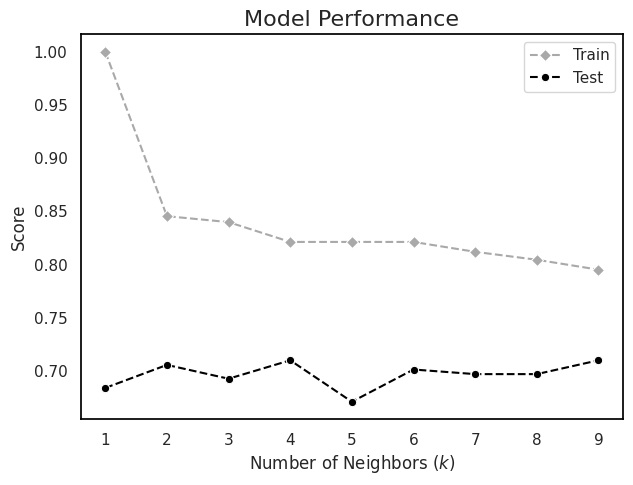

In [216]:
plot_model_performance(
      train_scores
    , test_scores
)

In [217]:
[value for value in test_scores if value != 1.0]

[0.683982683982684,
 0.7056277056277056,
 0.6926406926406926,
 0.70995670995671,
 0.670995670995671,
 0.7012987012987013,
 0.696969696969697,
 0.696969696969697,
 0.70995670995671]

In [218]:
best_test_score       = np.max([value for value in test_scores if value != 1.0])
best_test_score_index = test_scores.index(max(test_scores))

print(f"Best test_score: {best_test_score}")
print(best_test_score_index)

Best test_score: 0.70995670995671
3


Identify the number of neighbors that resulted in the max score in the training and test datasets. This will be the best (optimal) number of neighbors (i.e., $\large k_{optimal}$) we found for this small grid.

In [219]:
# We have to add 1 to best_test_score_index because test_scores start at K=1 not K=0
k_optimal_small_grid = best_test_score_index + 1
print(f"The number of neighbors k (or iteration) for which the maximum (best) test_score was achieved: {k_optimal_small_grid}")

The number of neighbors k (or iteration) for which the maximum (best) test_score was achieved: 4


The optimal number of neighbors value would typically be where the <b><code>test_score</code></b> :
  * Has the <b>highest</b> value ; OR
  * Starts to level off while the gap between the <b><code>train_score</code></b> and <b><code>test_score</code></b> is not too wide, suggesting that the model is generalizing well.

Here, the optimal number of neighbors is $k_{optimal}=4$ because:

* The <b><code>test_score</code></b> is relatively high and stable from this point onwards.

* The difference between the <b><code>train_score</code></b> and <b><code>test_score</code></b> is not as large as for
$k=1$, suggesting less overfitting.

### Predict

Now that we've determined the optimal number of neighbors or $k_{optimal}$ where our model performs at its best, it's time to assess its performance on new, unseen data.

We've identified the $k$ value that seems to yield the highest predictive accuracy during our training and tuning phases. However, the ultimate test lies in how well our model generalizes its learnings to make predictions on data it has never encountered before.

In simpler terms, we're now checking whether our model is truly good at making predictions, not just for the data it's seen before (i.e., <b><code>X_train</code></b> and <b><code>y_train</code></b> ), but for entirely new and unfamiliar data points (i.e., <b><code>X_test</code></b> ) (this is a critical step in assessing the real-world applicability and reliability of our model):

In [220]:
knn = KNeighborsClassifier(
    k_optimal_small_grid
)

knn.fit(
      X_train
    , y_train
)

KNeighborsClassifier(n_neighbors=4)

In [221]:
y_pred = knn.predict(
    X_test
)

### Evaluate

In [222]:
ytest_vs_ypred(
      y_test
    , y_pred
    , classes                    = ["No diabetes", "Diabetes"]
    , reset_index_col_name_to    = "Patien ID (row)"
    , num_rows_to_show_in_output = 10
)

,Actual label,Predicted label
Patien ID (row),,
668,No diabetes,No diabetes
324,No diabetes,No diabetes
624,No diabetes,No diabetes
690,No diabetes,No diabetes
473,No diabetes,No diabetes
204,No diabetes,Diabetes
97,No diabetes,No diabetes
336,No diabetes,Diabetes
568,No diabetes,No diabetes


#### Confusion Matrix

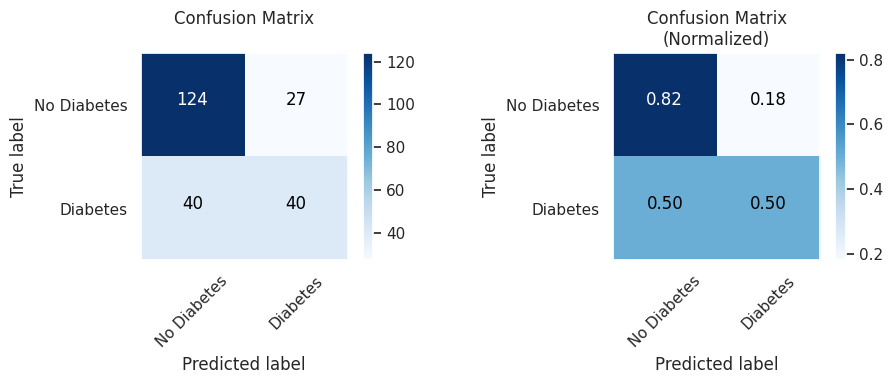

In [224]:
plot_confusion_matrix(
      y_test
    , y_pred
    , classes       = ["No Diabetes", "Diabetes"]
    , normalize     = True
    , show_colorbar = True

)

#### Classification Report

In [225]:
print(
    classification_report(
          y_test
        , y_pred
  )
)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       151
           1       0.60      0.50      0.54        80

    accuracy                           0.71       231
   macro avg       0.68      0.66      0.67       231
weighted avg       0.70      0.71      0.70       231



### Conclusions

* The model has a high accuracy in predicting non-diabetes cases, as indicated by the TNR of <b><code>0.82</code></b>.

* However, the model only correctly identifies half of the actual diabetes cases (TPR of <b><code>0.50</code></b>), which is a significant limitation, especially in a medical context where missing a diagnosis can have serious implications.

* The FNR is also <b><code>1-0.50=0.0.50</code></b>, which means that the model misses the other half of the actual diabetes cases, failing to diagnose them correctly.

* The FPR of <b><code>1-0.82=0.18</code></b> suggests that nearly 1 in 5 people without diabetes would be incorrectly diagnosed by the model as having diabetes, potentially leading to unnecessary stress and medical interventions.

---

## 5.2. KNN (Wide Grid)

In KNN algorithm, the $k$ parameter is one of the most important parameters affecting the model performance.  The model performance isn't horrible, <b>but what if we didn't consider a wide enough range of values in our neighbors for the KNN?</b>

An alternative to fitting a loop of models manually is to use a $\small\textbf{Grid Search}$ to identify the proper number of neighbors. It is common practice to use a <b><code>GridSearch</code></b> method for all <i>adjustable</i> parameters (<i>AKA</i> $\small\textbf{Hyperparameters}$) in any type of Machine Learning algorithm. To this end, follow these steps:

  1. Define the $\textbf{grid}$ (<i>AKA</i> <b>range of values</b>) to test in the parameter being optimized (here, number of neighbors or $k$ parameter).
  
  2. Compare (evaluate) the model performance based on the different values in the grid.

Run the code in the next cell to see how to implement the grid search method for identifying the best parameter value for the n_neighbors parameter. Notice the param_grid is the range value to test and we apply cross validation with five folds to score each possible value of n_neighbors as $k \in [1,50)$ :

In [226]:
# Define the range of values for hyperparameter k (number of neighbors)
k_values_wide_grid = np.arange(1, 50)

In [227]:
param_grid = {'n_neighbors' : k_values_wide_grid}

### Create & Fit

Now, follow these steps to set up another K-Nearest Neighbors (KNN) classifier and prepare it for hyperparameter tuning, using Cross-Validation (CV):

1. Create a <b><code>KNeighborsClassifier</code></b> classifier instance called <b><code>knn</code></b> .

2. Set up a <b><code>GridSearchCV</code></b> object, which will search for the best hyperparameters for the KNN classifier.

3. The <b><code>param_grid</code></b> variable should contain a dictionary specifying the hyperparameters and their corresponding values to be explored during the grid search.

4. Set the <b><code>cv</code></b> parameter to <b><code>5</code></b> to use 5-fold cross-validation to assess the performance of different hyperparameter combinations during the search.

5. Finally, make sure to ask GridSearchCV to return the train scores.

In [228]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(
      knn
    , param_grid
    , cv                 = 5
    , return_train_score = True
)

In [229]:
knn_cv.fit(
      X_train
    , y_train
)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

### Tuning Hyperparameter $k$

In [230]:
# print(knn_cv.cv_results_)

In [231]:
# Extract the cross-validation scores from the GridSearchCV results
train_scores = knn_cv.cv_results_['mean_train_score']
test_scores  = knn_cv.cv_results_['mean_test_score']

In [232]:
# for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores), 1):
#     print(f"Iteration {i}")
#     print(f"train_score = {train_score}")
#     print(f"test_score = {test_score}")
#     print('-'*40)

print_model_performance(
      range(len(test_scores))
    , train_scores
    , test_scores
)

 K  Train Score  Test Score
 0     1.000000    0.700000
 1     0.842173    0.718709
 2     0.843568    0.737418
 3     0.819834    0.739200
 4     0.824484    0.748512
 5     0.817037    0.744843
 6     0.809122    0.742939
 7     0.800744    0.724316
 8     0.794686    0.726237
 9     0.789102    0.728089
10     0.784916    0.728107
11     0.783052    0.731828
12     0.783055    0.739252
13     0.783519    0.739252
14     0.785844    0.741104
15     0.784911    0.739166
16     0.789565    0.739252
17     0.787235    0.744808
18     0.792359    0.748564
19     0.785383    0.733697
20     0.784451    0.737383
21     0.782583    0.741139
22     0.782116    0.737366
23     0.782585    0.741052
24     0.780722    0.737314
25     0.777934    0.733610
26     0.781195    0.731724
27     0.772351    0.741087
28     0.772350    0.742921
29     0.770952    0.744825
30     0.771881    0.737314
31     0.770482    0.739218
32     0.767223    0.739183
33     0.766762    0.735462
34     0.766761    0

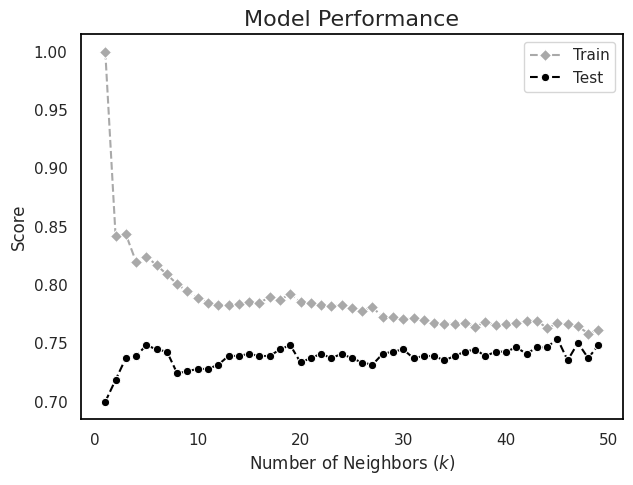

In [233]:
plot_model_performance(
      train_scores
    , test_scores
)

In [234]:
best_params = knn_cv.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'n_neighbors': 45}


### Predict

To make predictions, the <b><code>rfc_cv</code></b> model automatically selects the best hyperparameters that were determined during the grid search cross-validation process which is here:

<b><code>{'n_neighbors': 45}</code></b>

In [235]:
knn_cv.fit(
      X_train
    , y_train
)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

In [236]:
y_pred = knn_cv.predict(
    X_test
)

### Evaluate

In [237]:
ytest_vs_ypred(
      y_test
    , y_pred
    , classes                    = ["No diabetes", "Diabetes"]
    , reset_index_col_name_to    = "Patien ID (row)"
    , num_rows_to_show_in_output = 10
)

,Actual label,Predicted label
Patien ID (row),,
668,No diabetes,No diabetes
324,No diabetes,No diabetes
624,No diabetes,No diabetes
690,No diabetes,No diabetes
473,No diabetes,No diabetes
204,No diabetes,No diabetes
97,No diabetes,No diabetes
336,No diabetes,Diabetes
568,No diabetes,Diabetes


#### Confusion Matrix

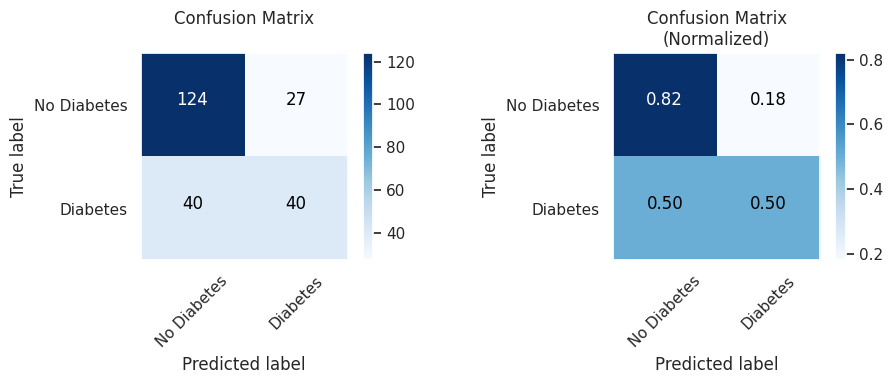

In [238]:
plot_confusion_matrix(
      y_test
    , y_pred
    , classes       = ["No Diabetes", "Diabetes"]
    , normalize     = True
    , show_colorbar = True

)

#### Classification Report

In [239]:
print(
    classification_report(
          y_test
        , y_pred
  )
)

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       151
           1       0.60      0.50      0.54        80

    accuracy                           0.71       231
   macro avg       0.68      0.66      0.67       231
weighted avg       0.70      0.71      0.70       231



### Conclusions

* The model has a high accuracy in predicting non-diabetes cases, as indicated by the TNR of <b><code>0.82</code></b>.

* However, the model only correctly identifies half of the actual diabetes cases (TPR of <b><code>0.50</code></b>), which is a significant limitation, especially in a medical context where missing a diagnosis can have serious implications.

* The FNR is also <b><code>1-0.50=0.0.50</code></b>, which means that the model misses the other half of the actual diabetes cases, failing to diagnose them correctly.

* The FPR of <b><code>1-0.82=0.18</code></b> suggests that nearly 1 in 5 people without diabetes would be incorrectly diagnosed by the model as having diabetes, potentially leading to unnecessary stress and medical interventions.

---

## 5.3. RandomForest

Now, following the KNN example, apply this grid search method to find the optimal number of estimators in a Randon Forest model.


In [240]:
rfc_param_grid = {
      'n_estimators' : [200, 500]
    , 'max_depth'    : [4, 5, 6, 7, 8]
    , 'criterion'    : ['gini', 'entropy']
}

### Create & Fit

In [241]:
rfc = RandomForestClassifier(
    random_state = 42
)

In [242]:
rfc_cv = GridSearchCV(
      estimator          = rfc
    , param_grid         = rfc_param_grid
    , cv                 = 5
    , return_train_score = True
)

In [243]:
rfc_cv.fit(
      X_train
    , y_train
)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]},
             return_train_score=True)

### Tuning Hyperparameter $k$

In [244]:
# # Access the cross-validation results
# rfc_cv.cv_results_

In [245]:
# Select only the relevant columns containing train and test scores
# Create a new DataFrame with only the train and test scores
train_scores, test_scores = rfc_cv.cv_results_['mean_train_score'], rfc_cv.cv_results_['mean_test_score']

In [246]:
print_model_performance(
      range(len(test_scores))
    , train_scores
    , test_scores
)

 K  Train Score  Test Score
 0     0.842640    0.754119
 1     0.844034    0.754102
 2     0.883144    0.752267
 3     0.882677    0.755954
 4     0.925043    0.756006
 5     0.924579    0.757823
 6     0.958567    0.763430
 7     0.959496    0.763430
 8     0.983708    0.763396
 9     0.983244    0.763430
10     0.841708    0.754136
11     0.839382    0.750398
12     0.871967    0.755971
13     0.872433    0.754102
14     0.910144    0.761561
15     0.911077    0.757823
16     0.947858    0.767134
17     0.951119    0.759709
18     0.972070    0.761578
19     0.976256    0.752233


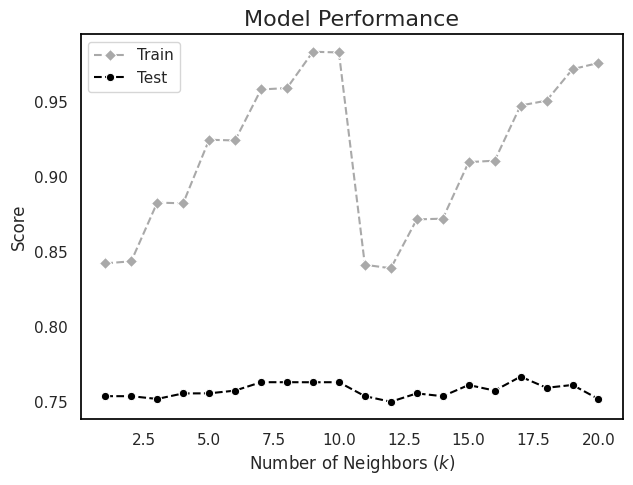

In [247]:
plot_model_performance(
      train_scores
    , test_scores
)

In [248]:
best_params = rfc_cv.best_params_
print(f"Best Parameters: {str(best_params)}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200}


### Predict

To make predictions, the <b><code>rfc_cv</code></b> model automatically selects the best hyperparameters that were determined during the grid search cross-validation process, which are here:

<b><code>{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200}</code></b>

In [249]:
y_pred = rfc_cv.predict(
    X_test
)

### Evaluate

In [250]:
ytest_vs_ypred(
      y_test
    , y_pred
    , classes                    = ["No diabetes", "Diabetes"]
    , reset_index_col_name_to    = "Patien ID (row)"
    , num_rows_to_show_in_output = 10
)

,Actual label,Predicted label
Patien ID (row),,
668,No diabetes,No diabetes
324,No diabetes,No diabetes
624,No diabetes,No diabetes
690,No diabetes,No diabetes
473,No diabetes,Diabetes
204,No diabetes,Diabetes
97,No diabetes,No diabetes
336,No diabetes,Diabetes
568,No diabetes,Diabetes


#### Confusion Matrix

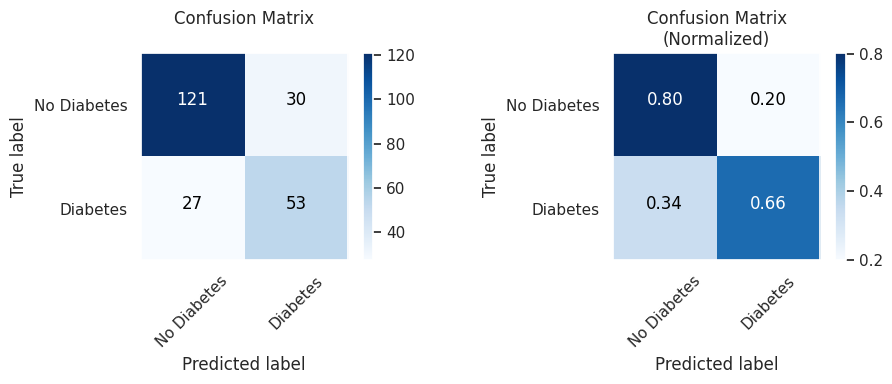

In [251]:
# Confusion matrix
# plot_confusion_matrix(
#       y_test
#     , y_pred
#     , classes = ["No Diabetes", "Diabetes"]

# )

# Normalized confusion matrix
plot_confusion_matrix(
      y_test
    , y_pred
    , classes       = ["No Diabetes", "Diabetes"]
    , normalize     = True
    , show_colorbar = True
)

#### Classification Report

In [252]:
print(
    classification_report(
          y_test
        , y_pred
  )
)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.76      0.75      0.75       231



### Conclusions

* The model has a higher accuracy in predicting non-diabetes cases compared to diabetes cases, as indicated by the higher TNR (<b><code>0.80</code></b>) compared to the TPR (<b><code>0.66</code></b>).

* The model has a non-negligible number of FNs, which is particularly concerning in medical diagnostics as it means that a significant proportion of patients with diabetes, i.e., <b><code>1-0.66=0.34</code></b> , were not identified by the model.

* The FPR of <b><code>1-0.80=0.20</code></b> indicates that 1 in 5 patients without diabetes was incorrectly diagnosed by the model as having diabetes, which could lead to unnecessary anxiety and medical procedures for these patients.

Improvements to the model might be needed to reduce both FPs and FNs, with a particular focus on reducing FNs due to the serious implications of missing a diagnosis of diabetes.